# Assignment 1: Supervised learning, Linear models, and Loss functions

In this assignment, you're going to write your own methods to fit a linear model using either an OLS or LAD cost function.  

## Data set

We will examine some data representing the miles-per-gallon of 398 cars given other variables describing them:

1. mpg: continuous. The miles-per-gallon of the car.
2. cylinders: multi-valued discrete. Number of cylinders.
3. displacement: continuous. Engine displacement of the car.
4. horsepower: continuous. Total horsepower of the car.
5. weight: continuous. Weight in lbs.
6. acceleration: continuous. Acceleration 0-60mph in seconds.
9. car name: string (unique for each instance, DO NOT USE)

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


## Preliminaries

In [1]:
# Import all the necessary packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.optimize as so
from sklearn import linear_model

%matplotlib inline

In [2]:
# Uncomment if using Google Colab or Kaggle Kernels.
# Imports the data using gdown.
!gdown https://drive.google.com/uc?id=1PtY3ne37XA8Jk_cAf0Cd7JSRvEU8KDbp

Downloading...
From: https://drive.google.com/uc?id=1PtY3ne37XA8Jk_cAf0Cd7JSRvEU8KDbp
To: /content/car_data.csv
100% 15.9k/15.9k [00:00<00:00, 16.0MB/s]



## Part 1
### Question 1.1:


Read the `car_data.csv` file as a `pandas.DataFrame` and show its descriptive statistics.  Investigate the relationship between the cars' weight and their mpg by plotting a scatter plot of the `weight` (x axis) and `mpg` columns (y axis). Add an `alpha` (transparency of the plotted dots) in case some data are overlapping. Remember to label your axes.

In [3]:
df = pd.read_csv('car_data.csv')
df.head()

,MPG,cylinders,displacement,horsepower,weight,acceleration,name
0,18.0,8,307.0,130,3504,12.0,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,ford torino


In [4]:
# Descriptive / Summary Statistics
df.describe()

,MPG,cylinders,displacement,horsepower,weight,acceleration
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


Text(0, 0.5, 'MPG (miles-per-gallon)')

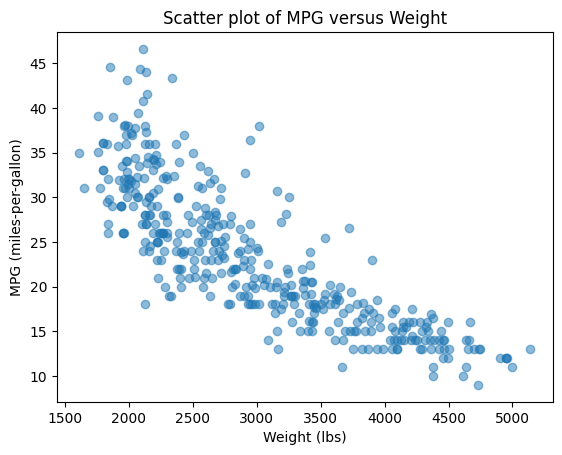

In [5]:
# Creating a scatter plot
plt.scatter(df['weight'], df['MPG'], alpha=0.5)

plt.title('Scatter plot of MPG versus Weight')
# Set x-axis label
plt.xlabel('Weight (lbs)')
# Set y-axis label
plt.ylabel('MPG (miles-per-gallon)')

**Written answer: What do you see here? Discuss your findings**

From the plot, we can observe an negative trend between the weight and the MPG of the car, indicating that heavier cars would have lower MPG. We can think it intuitively, heavier cars require more energy to operate, thus reducing the efficiency (MPG) of them.

### Question 1.2: point

Recall that the linear model, we obtain predictions by computing

$$ \hat{\mathbf{y}} = \mathbf{X} \hat{\beta} $$

Here, $\mathbf{X}$ is a design matrix which includes a column of ones, $\hat{\beta}$ are coefficients, and $\hat{\mathbf{y}}$ are outcomes.  Write a function `linearModelPredict` to compute linear model predictions given data and a coefficient vector.  The function should take as it's arguments a 1d-array of coefficients `b` and the design matrix `X` as a 2d-array and return linear model predictions `yp`.

Test the function by setting

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
```

Call your function using these values.

Report $\hat{\mathbf{y}}$. Print the dimensionality of the numpy-array that you get.

Hint:  Read the documentation for `np.dot` or the `@` operator in `numpy`.

In [6]:
# Defining the function
def linearModelPredict(beta, X):
  if len(beta.shape) == 1:
    beta = beta.reshape(-1,1)
  if len(X.shape) == 1:
    X = X.reshape(-1,1)
  if beta.shape[0] != X.shape[1]:
    raise Exception(f"Number of columns in beta ({beta.shape[0]}) is different from the number of rows in X ({X.shape[1]})")

  return X@beta

In [7]:
# Testing the function
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])

hat_y = linearModelPredict(b,X)
print(hat_y)

[[ 0.1]
 [-0.2]
 [ 0.7]]


In [8]:
print(hat_y.shape)

(3, 1)


### Question 1.3:

Write a function `linearModelMSE` which computes and returns the mean squared error parameterized by $\beta$, as well as the gradient of the loss.  The function should take as its first argument a 1D-array `beta` of coefficients for the linear model, as its second argument the design matrix `X` as a 2D-array, and as its third argument a 1D-array `y` of observed outcomes. Recall that:

$$
MSE(y_i, \hat{y_i}) = \frac{1}{|I|} \sum_i (y_i - \hat{y_i})^2
$$
$$
\nabla MSE(y, \hat{y}) = -\frac{2}{|I|} \left[(y-\hat{y}) \cdot X\right]
$$

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.



In [9]:
# Defining the function
def mse(y_real, y_pred):
    y_real = np.array(y_real).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    assert y_real.shape == y_pred.shape, "The two vectors must have the same shape"
    return np.mean((y_real - y_pred)**2)

In [10]:
# Testing the function
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])

print(mse(y, hat_y))

0.6866666666666666


**Written answer**: To minimize the loss, do you need increase or decrease the value of the parameters?

The value of the parameters should be adjusted (either increase or decrease) based on how they influence the error. The optimisation algorithm would help us to decide whether the how the adjustment will be.

### Question 1.4:

Now that you've implemented a loss function in question 1.3, it is now time to minimize it!

Write a function `linearModelFit` to fit a linear model.  The function should take as its first argument the design matrix `X` as a 2D-array, as its second argument a 1D-array `y` of outcomes, and as its third argument a function  `lossfcn` which returns as a tuple the value of the loss, as well as the gradient of the loss. As a result, it should return the estimated betas and the $R^2$. Pass the argument `jac=True` to the `miminize` function so that it uses your gradient.

Test the function with the values:
```
X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2])
```

Report the best parameters and the fitted $R^2$.


In [11]:
# Create the first guess
beta0 = np.array([1.1,-1])
X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2]).reshape(-1,1)
print(f"X shape: {X.shape}, y shape: {y.shape}, beta0 shape: {beta0.shape}")

X shape: (3, 2), y shape: (3, 1), beta0 shape: (2,)


In [12]:
# Import required package
from scipy.optimize import minimize

# Define the loss function
def loss(beta, X, y):
    y_pred = linearModelPredict(beta, X)
    return mse(y, y_pred)


# Perform optimastion
res = minimize(loss, beta0, args=(X, y))
beta_opt = res.x
print(f"The optimal beta values are: {beta_opt}")

The optimal beta values are: [0.59999997 0.59999997]


In [13]:
# Convert MSE to SSE
ss_res = res.fun*len(y)

# Calculate the total sum of squares
ss_tot = np.sum((y - np.mean(y))**2)

# Compute R-squared
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

R-squared: 0.7499999999999956


### Question 1.5:

Use the above functions to fit your model to the car data. Use the MPG as the target (y) variable and only the weight variable as the independent (x). Fit the model with a constant. Then use your model and the fitted parameters to make predictions along a grid of equally spaced weights within the original range of the weight variable.  

Plot the data and add a line for the predicted values. You can get these by generating a new X-matrix with 100 equally space weights (using for example [```np.linspace```](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)). Also report the $R^2$ value for the fit. You can do this by either printing out the $R^2$ of the fit or putting it on your plot via the `annotate` function in matplotlib.


In [14]:
# Import the package
from sklearn.linear_model import LinearRegression

In [15]:
# First, we create X, where the 1st column is the constant terms and 2nd column 2 is the "weight"
has_nan = np.invert(df.loc[:, ['weight', 'MPG']].isna().any(axis=1))
X = df.loc[has_nan, ['weight']]
X = np.hstack([np.ones((X.shape[0], 1)), X])
print(f"X shape: {X.shape}")

X shape: (392, 2)


In [16]:
# Then, we create y, the actual values of the prediction results: column "MPG"
# Reshape is needed
y = np.array(df.loc[has_nan, 'MPG']).reshape(-1,1)
print(f"y shape: {y.shape}")

y shape: (392, 1)


In [17]:
# Thus, we create our initial guess on the beta
beta0 = np.array([1,-1])
print(f"beta0 shape: {beta0.shape}")

beta0 shape: (2,)


In [18]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [19]:
beta_sklearn = model.coef_
beta_sklearn

array([[ 4.62165245e+01, -7.64734254e-03]])

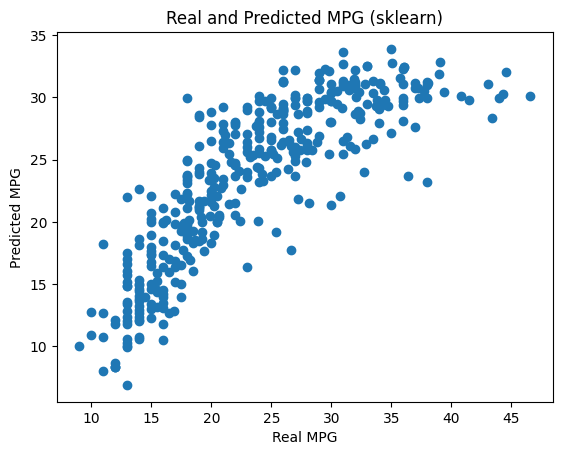

In [20]:
# Predict the pressure using the sklearn model
y_pred_sk = model.predict(X)

# Plot a scatter plot of the real pressure values against the predicted pressure values
plt.scatter(y, y_pred_sk)
plt.xlabel('Real MPG')
plt.ylabel('Predicted MPG')
plt.title('Real and Predicted MPG (sklearn)')
plt.show()

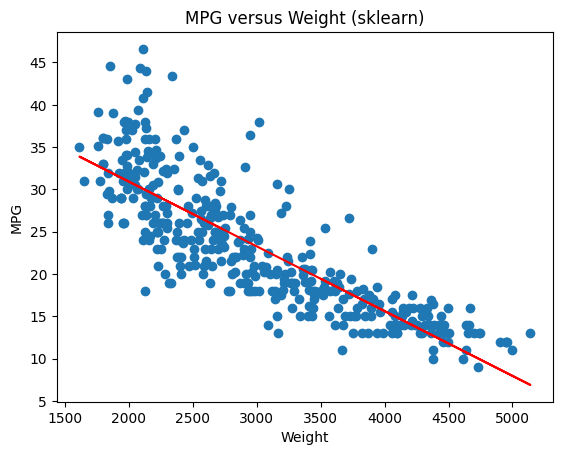

In [21]:
plt.scatter(df.loc[has_nan, "weight"], y)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.title('MPG versus Weight (sklearn)')
plt.plot(df.loc[has_nan, "weight"], y_pred_sk, color = "red")
plt.show()

In [22]:
first_R2 = model.score(X, y)
print("The R-squared value is :", first_R2)

The R-squared value is : 0.6926304331206254


### Question 1.6:

Now use sklearn's `linear_model` to fit the model with all the available data. Plot the data and add a line for the predicted values as you did in the previous question. Also report the $R^2$ value for the fit.

**Written answer: How much do you gain by having more variables?**

In [23]:
sub_df = df.iloc[:,1:6]
sub_df.head()

,cylinders,displacement,horsepower,weight,acceleration
0,8,307.0,130,3504,12.0
1,8,350.0,165,3693,11.5
2,8,318.0,150,3436,11.0
3,8,304.0,150,3433,12.0
4,8,302.0,140,3449,10.5


In [24]:
# Import the package
from sklearn.linear_model import LinearRegression

In [25]:
X = np.hstack([np.ones((X.shape[0], 1)), sub_df])
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (392, 6)
y shape: (392, 1)


In [26]:
beta0 = np.array([1,1,1,1,1,1])
print(f"beta0 shape: {beta0.shape}")

beta0 shape: (6,)


In [27]:
model_all_predictors = LinearRegression(fit_intercept=False)
model_all_predictors.fit(X, y)

LinearRegression(fit_intercept=False)

In [28]:
# Get the beta values
beta_all_predictors_sklearn = model_all_predictors.coef_
beta_all_predictors_sklearn

array([[ 4.62643079e+01, -3.97928359e-01, -8.31301222e-05,
        -4.52570802e-02, -5.18691735e-03, -2.91047140e-02]])

In [29]:
y_all_predictors_sk = model_all_predictors.predict(X)

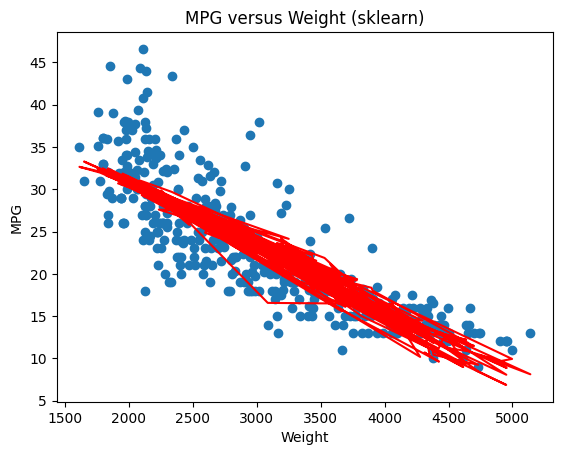

In [30]:
plt.scatter(df.loc[has_nan, "weight"], y)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.title('MPG versus Weight (sklearn)')
plt.plot(df.loc[has_nan, "weight"], y_all_predictors_sk, color = "red")
plt.show()

In [31]:
R2_all_predictors = model_all_predictors.score(X, y)
print("The R-squared value is :", R2_all_predictors)

The R-squared value is : 0.7076926326770516


In [32]:
print("Gain in R-squared value by including all variables as predicors: ", R2_all_predictors-first_R2)

Gain in R-squared value by including all variables as predicors:  0.015062199556426181


## Part 2: LAD Regression

### Question 2.1:

In the previous section, we worked with the squared loss.  Now, we'll implement a linear model with least absolute deviation loss $LAD(y_i, \hat{y_i})$.

$$
LAD(y_i, \hat{y_i}) = \frac{1}{|I|}\sum_i |y_i - \hat{y_i}|
$$

where $y_i$ is the true label of sample $i \in I$, $\hat{y_i}$ is the prediction, $I$ is the sample set, and $|I|$ is the number of cases in the sample. The gradient of the function is:

$$
\nabla LAD(y, \hat{y}) = - \frac{ sign(y_i - \hat{y_i}) \cdot X}{|I|}
$$

with `sign` the sign function. Note this function is undefined at 0.

Write a function `linearModelLossLAD` which computes the least absolute deviation loss function for a linear model parameterized by $\beta$, as well as the gradient of the loss, following the same structured as the previous part.

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.

In [33]:
# Defining the loss function
def linearModelLossLAD (X,y,beta):
  # Computing loss
  residuals = (y.reshape(-1, 1) - X@beta.reshape(-1, 1))
  loss = np.mean(np.abs(residuals))
  # Computing gradient
  signs = np.sign(residuals)
  gradient = -((signs.T@X) / len(X))
  return loss, gradient

In [34]:
# Testing
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])

test_model = linearModelLossLAD(X,y,b)
print(f"LAD Loss = {test_model[0]}")
print(f"Gradient = {test_model[1].tolist()}")

LAD Loss = 0.6666666666666666
Gradient = [[-0.3333333333333333, -0.3333333333333333]]


From the result of the code above, the LAD Loss $\approx 0.667$ and the Gradient approximately equals $[-0.33, -0.33]$


### Question 2.2:


Use the above functions to fit your LAD model using the weight variable as input, to predict the mpg. Use your model to make predictions along a grid of 100 equally spaced car weights.  Once fit, add the fitted line to the scatter plot as in question 1.5.  Also report the $R^2$-value.

**Written answer**: What is the difference in the fit obtained with an $L_1$ as compared to the $L_2$ cost function? How do their $R^2$ values compare? Why?  

Note: If you receive an error from the optimizer, it may be because the loss function for the LAD model is not differentiable at its minimum.  This will lead to some gradient-based optimizers to fail to converge.  If this happens to you then pass `method="Powell"` to `scipy.optimize.minimize`.



In [35]:
# First, we create X, where the 1st column is the constant terms and 2nd column 2 is the "weight"
has_nan = np.invert(df.loc[:, ['weight', 'MPG']].isna().any(axis=1))
X = df.loc[has_nan, ['weight']]
X = np.hstack([np.ones((X.shape[0], 1)), X])
print(f"X shape: {X.shape}")

X shape: (392, 2)


In [36]:
# Then, we create y, the actual values of the prediction results: column "MPG"
# Reshape is needed
y = np.array(df.loc[has_nan, 'MPG']).reshape(-1,1)
print(f"y shape: {y.shape}")

y shape: (392, 1)


In [37]:
# Thus, we create our initial guess on the beta
beta0 = np.array([1,-1])
print(f"beta0 shape: {beta0.shape}")

beta0 shape: (2,)


In [38]:
print(f"X shape: {X.shape}, y shape: {y.shape}, beta0 shape: {beta0.shape}")

X shape: (392, 2), y shape: (392, 1), beta0 shape: (2,)


In [39]:
from scipy.optimize import minimize

def loss(beta, X, y):
  if len(beta.shape) == 1:
    beta = beta.reshape(-1,1)
  if len(X.shape) == 1:
    X = X.reshape(-1,1)
  if len(y.shape) == 1:
    y = y.reshape(-1,1)
  loss, gradient = linearModelLossLAD(X,y,beta)
  return loss
  # return np.mean(np.abs(y - (X@beta)))

result = minimize(loss, beta0, args=(X, y), method="Powell")

# Summary of the result
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.2477221381129797
       x: [ 4.411e+01 -7.107e-03]
     nit: 5
   direc: [[-2.474e+03  7.788e-01]
           [ 9.908e-02 -2.820e-07]]
    nfev: 202


In [40]:
# Optimal beta values
beta_opt = result.x
print(f"Optimal beta values: {beta_opt}")

Optimal beta values: [ 4.41071968e+01 -7.10690015e-03]


In [41]:
y_lad = X@beta_opt

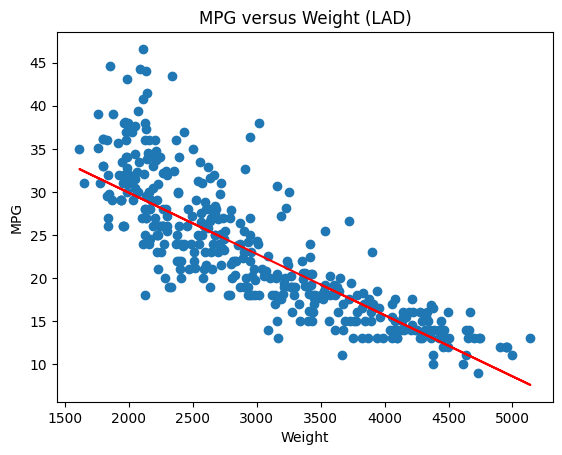

In [42]:
plt.scatter(df.loc[has_nan, "weight"], y)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.title('MPG versus Weight (LAD)')
plt.plot(df.loc[has_nan, "weight"], y_lad, color = "red")
plt.show()

In [43]:
# Compute SSE
ss_res = np.mean((y - y_lad)**2)
# Total sum of absolute deviations from the median
median_y = np.median(y)
ss_tot = np.sum(np.abs(y - median_y))
# R-squared
r2_lad = 1 - (ss_res / ss_tot)
print(f"R-squared value for LAD Regression: {r2_lad:.4f}")

R-squared value for LAD Regression: 0.9619


In [44]:
print("Gain in R-squared value by using LAD regression instead of OLS regression with all variables as predicors: ", r2_lad-R2_all_predictors)

Gain in R-squared value by using LAD regression instead of OLS regression with all variables as predicors:  0.25423719312632187


### Question 2.3:

Now we will use all data for the fit. Fit an LAD model to the car data (excluding the name) with the `linear_model` module from the `sklearn` package by using the [`QuantileRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor) class that implements a [pinball loss](https://en.wikipedia.org/wiki/Quantile_regression), a more general case of the [`mean_absolute_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html) loss. To get an MAD regression, set the parameters `alpha=0` and `quantile=0.5` in the `QuantileRegressor` call.

In no more than two sentences, comment on the $R^2$ values for both the OLS and MAD regressions. Use the `sklearn` models for this analysis. Are they similar? Make a scatterplot of the sklearn's OLS and MAD predictions.

In [45]:
# Import required package
from sklearn.linear_model import QuantileRegressor

In [46]:
sub_df.head()

,cylinders,displacement,horsepower,weight,acceleration
0,8,307.0,130,3504,12.0
1,8,350.0,165,3693,11.5
2,8,318.0,150,3436,11.0
3,8,304.0,150,3433,12.0
4,8,302.0,140,3449,10.5


In [47]:
mad = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
mad.fit(sub_df, y)
y_pred_mad = mad.predict(sub_df)

# Calculate R-squared value
r2_mad = mad.score(sub_df, y)
print(f"R-squared value for MAD: {r2_mad:.4f}")
print(f"R-squared value for OLD: {R2_all_predictors:.4f}")

R-squared value for MAD: 0.6922
R-squared value for OLD: 0.7077


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The R-squared values for both the OLS and MAD regressions are nearly identical, indicating that both models explain a similar proportion of the variance in MPG based on weight. This similarity suggests that, for this dataset, both regression approaches perform comparably in terms of explanatory power.